In [ ]:
import os

import joblib
import kagglehub
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [ ]:
DATA_PATH = "diamonds.csv"
TARGET_COL = "price"
MODEL_PATH = "diamond_pricing_model.joblib"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [ ]:
def load_data(path: str) -> pd.DataFrame:
  if not os.path.exists(path):
    raise FileNotFoundError()
  df = pd.read_csv(path)
  print(f'Loaded initial dataset with shape {df.shape}')
  return df

In [ ]:
path = kagglehub.dataset_download("zahranusrat/diamonds-characteristics-and-pricing-analysis")

df_raw = load_data(DATA_PATH)
X = df_raw.drop(TARGET_COL, axis=1)
y = df_raw[TARGET_COL]

df_raw.info()
df_raw.describe().T

Using Colab cache for faster access to the 'diamonds-characteristics-and-pricing-analysis' dataset.
Loaded initial dataset with shape (53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
 9   price    53940 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00


In [ ]:
df_raw.iloc[:5,:]

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


In [ ]:
for col in df_raw.columns:
  print(f'{df_raw[col].value_counts()}')

carat
0.30    2604
0.31    2249
1.01    2242
0.70    1981
0.32    1840
        ... 
3.50       1
2.70       1
3.40       1
4.00       1
3.67       1
Name: count, Length: 273, dtype: int64
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64
depth
62.0    2239
61.9    2163
61.8    2077
62.2    2039
62.1    2020
        ... 
52.2       1
53.4       1
72.2       1
72.9       1
54.7       1
Name: count, Length: 184, dtype: int64
table
56.0    9881
57.0    9724
58.0    8369
59.0    6572
55.0    6268
        ... 
63.4       1
62.1       1
79.0       1
76.0       1
61.6       1
Name: count, Length: 127, dtype: int64
x
4.37     448
4.34     437
4.33     429
4.38     428
4.

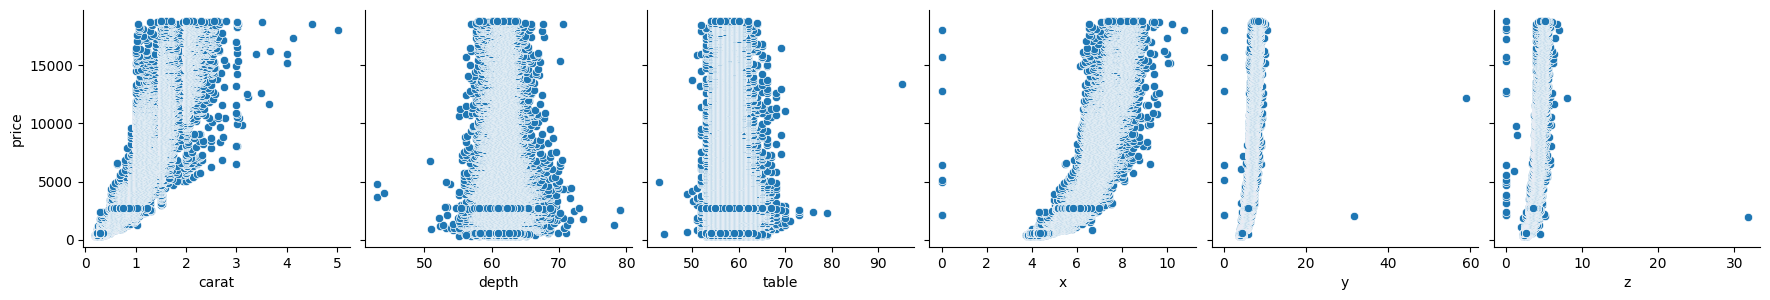

In [ ]:
X.select_dtypes(include=['int64', 'float64']).columns.tolist()

sns.pairplot(
    data=df_raw,
    x_vars=X.select_dtypes(include=['int64', 'float64']).columns.tolist(),
    y_vars=['price'],
    height=3
)

In [ ]:
diamonds_num = df_raw.select_dtypes(include=['int64,float64'])

for i in range(0, len(diamonds_num.columns),3):
  sns.pairplot(
      data=diamonds_num,
      x_vars=diamonds_num.columns[i,i+3],
      y_vars=['price'],
      height=3
  )

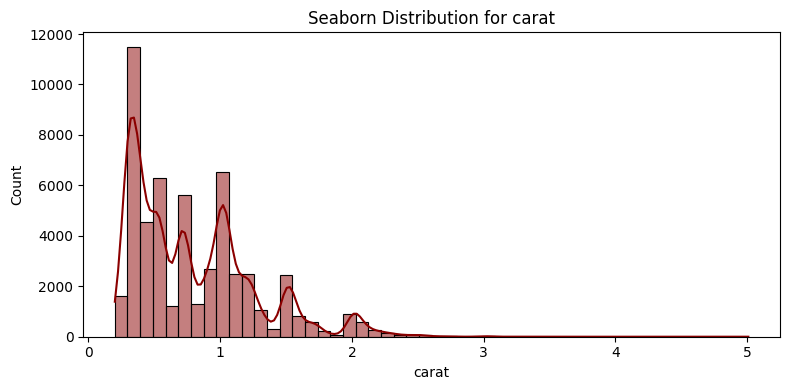

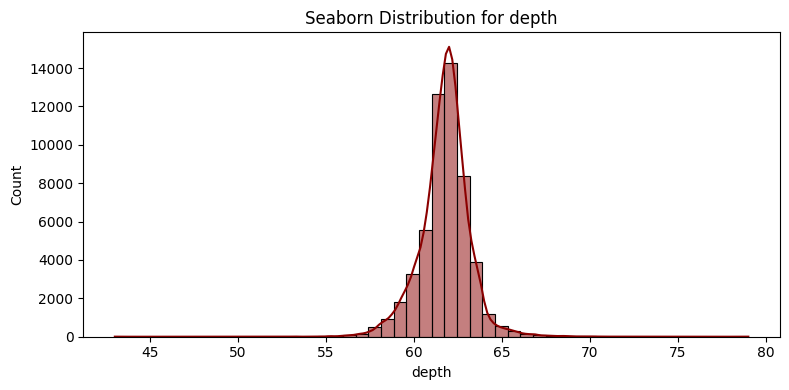

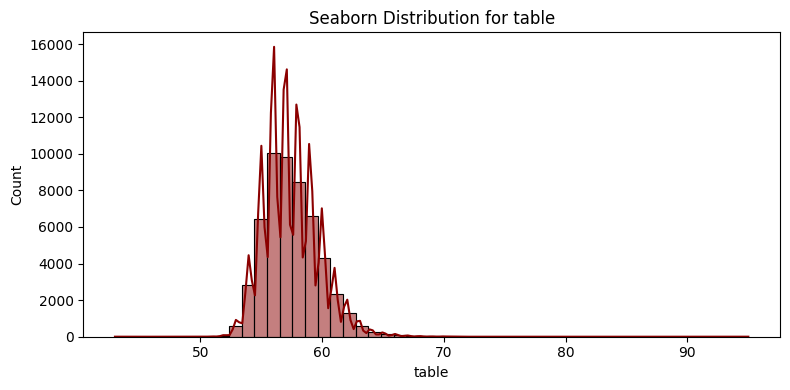

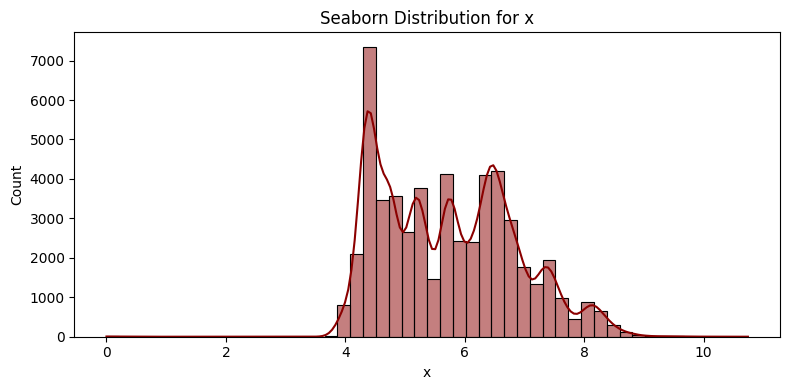

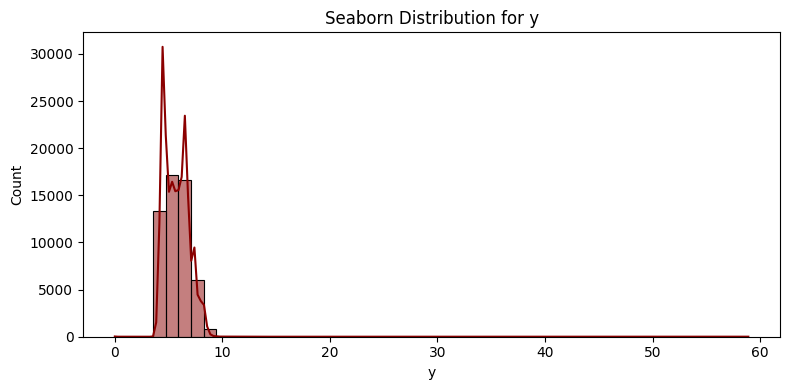

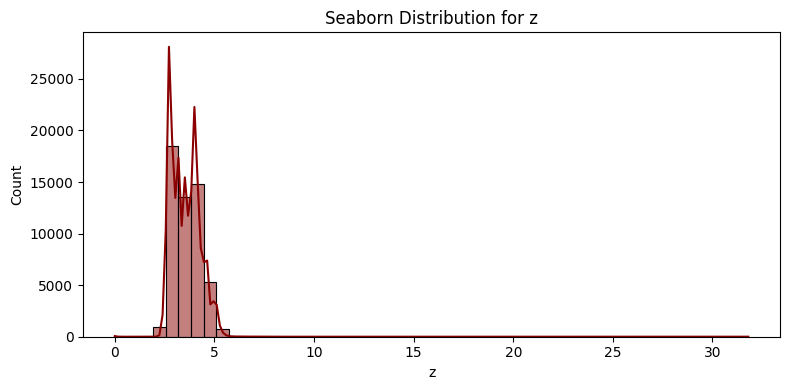

In [ ]:
numeric_cols = X.select_dtypes(include=np.number).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_raw[col], kde=True, bins=50, color='darkred')
    plt.title(f"Seaborn Distribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

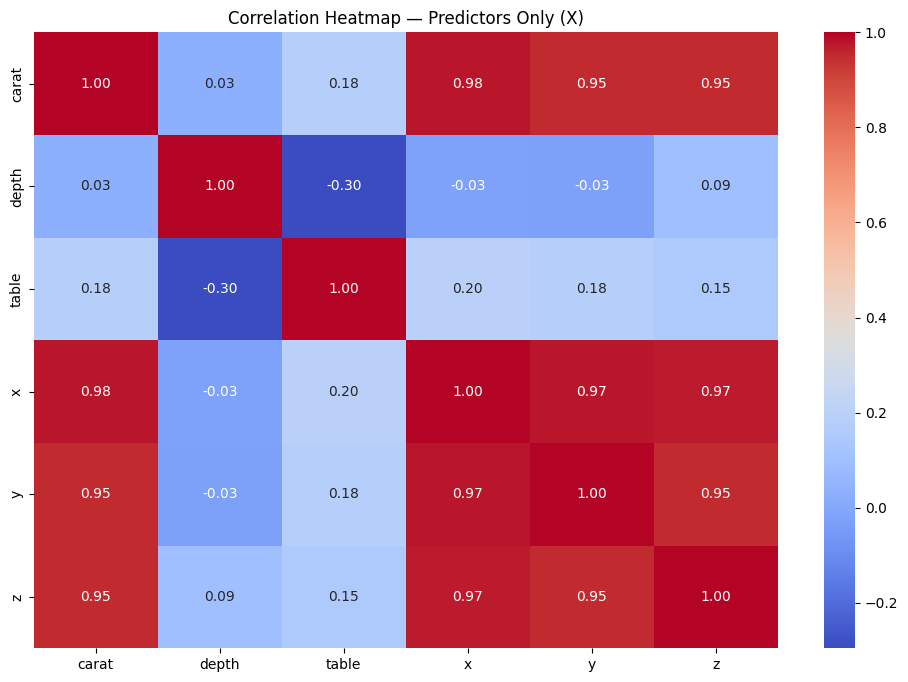

In [ ]:
num_cols_X = X.select_dtypes(include=np.number)

plt.figure(figsize=(12, 8))
sns.heatmap(num_cols_X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap — Predictors Only (X)")
plt.show()

/tmp/ipython-input-2069579636.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['x'])


<Axes: xlabel='x', ylabel='Density'>

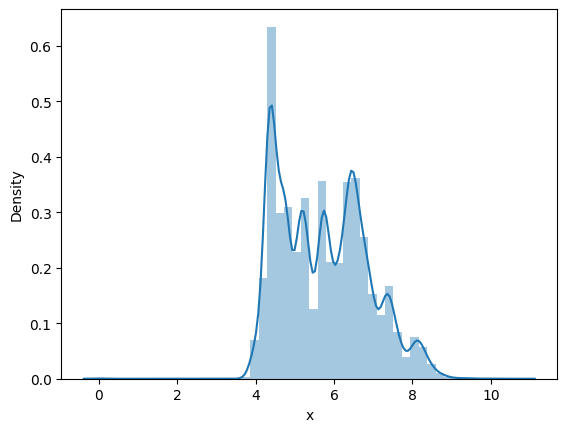

In [ ]:
sns.distplot(df_raw['x'])

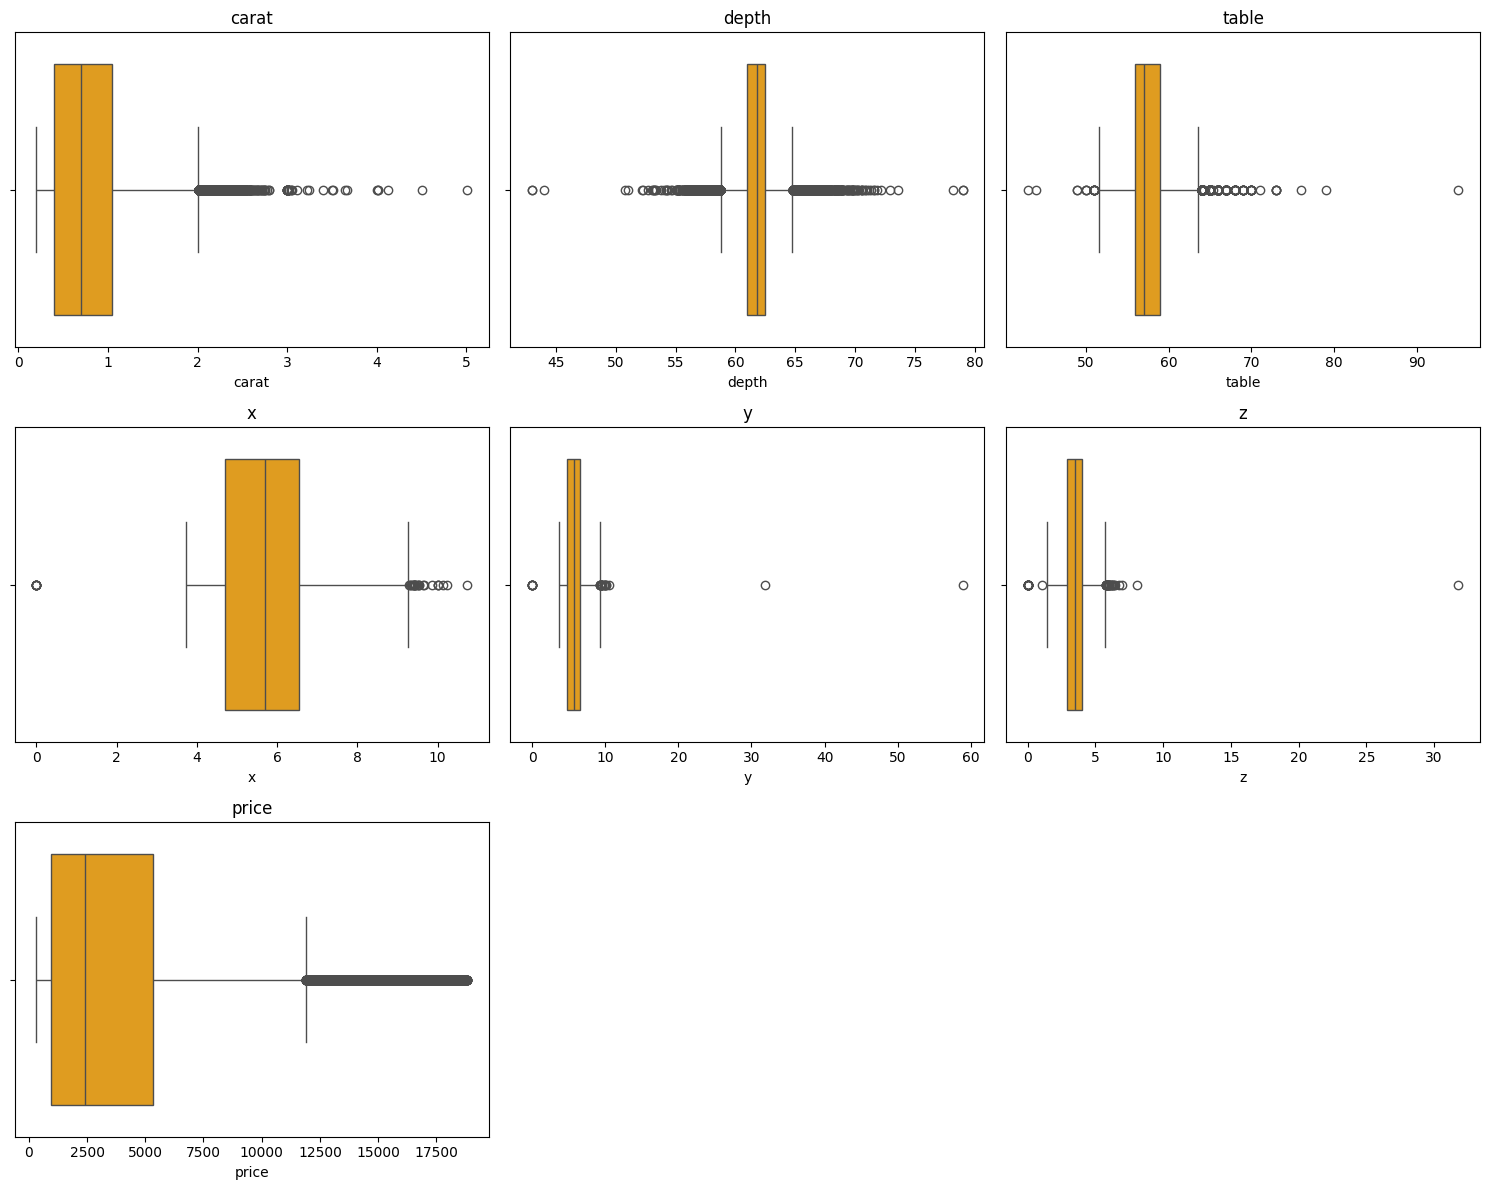

In [ ]:
numeric_cols = df_raw.select_dtypes(include=np.number).columns
n = len(numeric_cols)

plt.figure(figsize=(15, 4 * ((n + 2) // 3)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((n + 2) // 3, 3, i)
    sns.boxplot(x=df_raw[col], color='orange')
    plt.title(col)

plt.tight_layout()
plt.show()